/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating resnet50: 100%|██████████| 2/2 [01:39<00:00, 49.72s/it]



Accuracy for resnet50: 0.9020
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.92      0.95      0.94        38

    accuracy                           0.90        51
   macro avg       0.88      0.86      0.87        51
weighted avg       0.90      0.90      0.90        51



Evaluating efficientnet_b0: 100%|██████████| 2/2 [00:40<00:00, 20.18s/it]



Accuracy for efficientnet_b0: 0.8235
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.89      0.87      0.88        38

    accuracy                           0.82        51
   macro avg       0.77      0.78      0.77        51
weighted avg       0.83      0.82      0.83        51



Evaluating densenet121: 100%|██████████| 2/2 [01:26<00:00, 43.30s/it]



Accuracy for densenet121: 0.8235
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.85      0.92      0.89        38

    accuracy                           0.82        51
   macro avg       0.78      0.73      0.75        51
weighted avg       0.81      0.82      0.82        51



Evaluating vit_base_patch16_224: 100%|██████████| 2/2 [00:45<00:00, 22.50s/it]



Accuracy for vit_base_patch16_224: 0.7451
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        13
           1       0.86      0.79      0.82        38

    accuracy                           0.75        51
   macro avg       0.68      0.70      0.69        51
weighted avg       0.77      0.75      0.75        51



Evaluating swin_base_patch4_window7_224: 100%|██████████| 2/2 [00:53<00:00, 26.75s/it]


Accuracy for swin_base_patch4_window7_224: 0.8824
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.90      0.95      0.92        38

    accuracy                           0.88        51
   macro avg       0.86      0.82      0.84        51
weighted avg       0.88      0.88      0.88        51



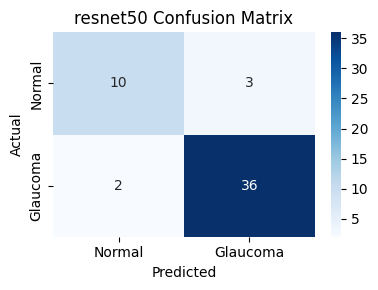

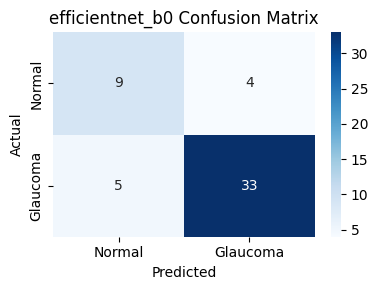

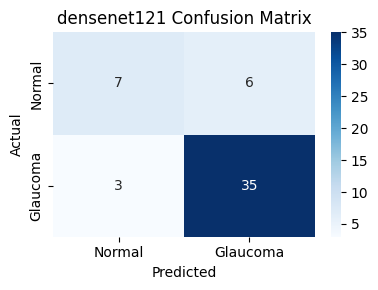

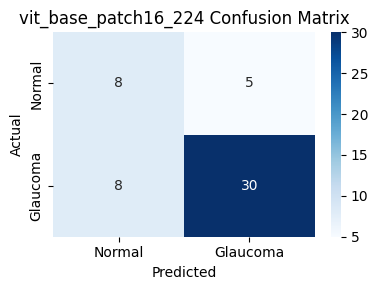

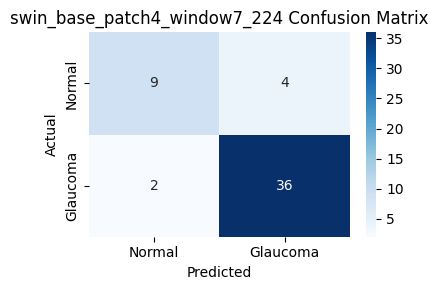

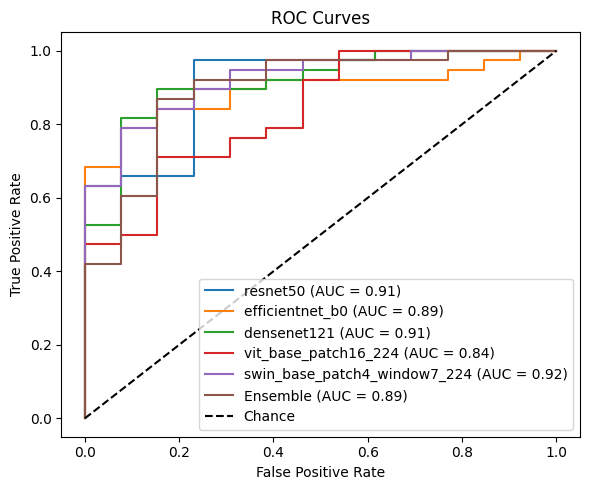

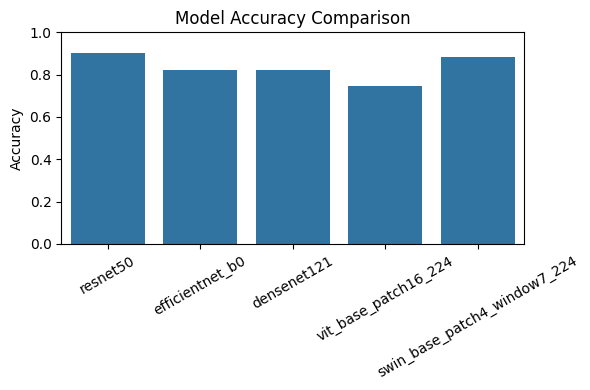


=== Model Performance Summary ===


,Model,Accuracy,Precision,Recall,F1-score,AUC
0,resnet50,0.9020,0.9002,0.9020,0.9006,0.9089
1,swin_base_patch4_window7_224,0.8824,0.8791,0.8824,0.8790,0.9211
2,Ensemble,0.8627,0.8599,0.8627,0.8609,0.8927
3,efficientnet_b0,0.8235,0.8284,0.8235,0.8256,0.8907
4,densenet121,0.8235,0.8145,0.8235,0.8154,0.9130
5,vit_base_patch16_224,0.7451,0.7661,0.7451,0.7530,0.8360


In [ ]:
import os
import cv2
import torch
import timm
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.models import resnet50, efficientnet_b0
from torchvision.models.densenet import DenseNet
from albumentations.pytorch import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt
import zipfile
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# ==== CLAHE and Transforms ====

def apply_clahe(img, **kwargs):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def get_transforms_cnn():
    return A.Compose([
        A.Lambda(image=apply_clahe),
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_transforms_transformer():
    return A.Compose([
        A.Lambda(image=apply_clahe),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# ==== Dataset Class ====

class GlaucomaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image cannot be read: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label, img_path

# ==== Unzip Dataset ====

with zipfile.ZipFile("/content/drishti_test.zip", 'r') as zip_ref:
    zip_ref.extractall()

# ==== Prepare DataFrame ====

test_dir = "/content/Test/Images"
label_map = {'Normal': 0, 'Glaucoma': 1}
test_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    for img_name in os.listdir(label_dir):
        test_data.append({
            'image_path': f'{label}/{img_name}',
            'label': label_map[label]
        })

test_df = pd.DataFrame(test_data)

# ==== Model Setup ====

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = {
    "resnet50": "/content/resnet50_best.pth",
    "efficientnet_b0": "/content/efficientnet_b0_best.pth",
    "densenet121": "/content/densenet121_best.pth",
    "vit_base_patch16_224": "/content/vit_base_patch16_224_best.pth",
    "swin_base_patch4_window7_224": "/content/swin_base_patch4_window7_224_best.pth"
}

class PatchedDenseNet(DenseNet):
    def forward(self, x):
        features = self.features(x)
        features = features.clone()
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

models = {}

models['resnet50'] = resnet50(pretrained=False, num_classes=2)
models['resnet50'].load_state_dict(torch.load(model_paths['resnet50'], map_location=device))
models['resnet50'].eval().to(device)

models['efficientnet_b0'] = efficientnet_b0(pretrained=False, num_classes=2)
models['efficientnet_b0'].load_state_dict(torch.load(model_paths['efficientnet_b0'], map_location=device))
models['efficientnet_b0'].eval().to(device)

models['densenet121'] = PatchedDenseNet(
    growth_rate=32, block_config=(6, 12, 24, 16),
    num_init_features=64, bn_size=4, drop_rate=0, num_classes=2
)
models['densenet121'].load_state_dict(torch.load(model_paths['densenet121'], map_location=device))
models['densenet121'].eval().to(device)

models['vit_base_patch16_224'] = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
models['vit_base_patch16_224'].load_state_dict(torch.load(model_paths['vit_base_patch16_224'], map_location=device))
models['vit_base_patch16_224'].eval().to(device)

models['swin_base_patch4_window7_224'] = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=2)
models['swin_base_patch4_window7_224'].load_state_dict(torch.load(model_paths['swin_base_patch4_window7_224'], map_location=device))
models['swin_base_patch4_window7_224'].eval().to(device)

# ==== Transforms for each model ====

transform_map = {
    "resnet50": get_transforms_cnn(),
    "efficientnet_b0": get_transforms_cnn(),
    "densenet121": get_transforms_cnn(),
    "vit_base_patch16_224": get_transforms_transformer(),
    "swin_base_patch4_window7_224": get_transforms_transformer()
}

# ==== Evaluation Function ====

def evaluate_model(model, transform, model_name):
    dataset = GlaucomaDataset(test_df, root_dir="/content/Test/Images", transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels, _ in tqdm(loader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_probs.extend(probs)

    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy for {model_name}: {acc:.4f}")
    print(classification_report(y_true, y_pred))

    return y_true, y_pred, y_probs, acc

# ==== Run All Models and Ensemble ====

results = {}
ensemble_probs = np.zeros(len(test_df))
y_true_reference = None

for model_name, model in models.items():
    y_true, y_pred, y_probs, acc = evaluate_model(model, transform_map[model_name], model_name)

    if y_true_reference is None:
        y_true_reference = y_true
    else:
        assert y_true_reference == y_true, f"Inconsistent y_true from {model_name}"

    results[model_name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_probs": y_probs,
        "accuracy": acc
    }

    ensemble_probs += np.array(y_probs)

ensemble_probs /= len(models)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# ==== Confusion Matrix Function ====

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ==== ROC Curve Function ====

def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# ==== Plot Individual Confusion Matrices ====

for model_name, data in results.items():
    plot_confusion_matrix(data['y_true'], data['y_pred'], title=f"{model_name} Confusion Matrix")

# ==== Plot ROC Curves ====

plt.figure(figsize=(6, 5))
for model_name, data in results.items():
    plot_roc_curve(data['y_true'], data['y_probs'], model_name)
plot_roc_curve(y_true_reference, ensemble_probs, "Ensemble")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ==== Model Accuracies ====

plt.figure(figsize=(6, 4))
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
sns.barplot(x=model_names, y=accuracies)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ==== Metrics Summary Table ====

metrics_list = []

for model_name, data in results.items():
    report = classification_report(data['y_true'], data['y_pred'], output_dict=True, zero_division=0)
    fpr, tpr, _ = roc_curve(data['y_true'], data['y_probs'])
    auc_score = auc(fpr, tpr)
    metrics_list.append({
        "Model": model_name,
        "Accuracy": accuracy_score(data['y_true'], data['y_pred']),
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"],
        "AUC": auc_score
    })

# Add ensemble
ensemble_report = classification_report(y_true_reference, ensemble_preds, output_dict=True)
fpr, tpr, _ = roc_curve(y_true_reference, ensemble_probs)
ensemble_auc = auc(fpr, tpr)

metrics_list.append({
    "Model": "Ensemble",
    "Accuracy": accuracy_score(y_true_reference, ensemble_preds),
    "Precision": ensemble_report["weighted avg"]["precision"],
    "Recall": ensemble_report["weighted avg"]["recall"],
    "F1-score": ensemble_report["weighted avg"]["f1-score"],
    "AUC": ensemble_auc
})

results_df = pd.DataFrame(metrics_list)
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
results_df = results_df.round(4)

print("\n=== Model Performance Summary ===")
display(results_df)